In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import copy
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/content/drive/MyDrive/induction_motor')
import modules,scaler


In [4]:
normal_data = pd.read_csv('/content/drive/MyDrive/induction_motor/combined_data.csv')


In [5]:
anomalous_data = pd.read_csv('/content/drive/MyDrive/induction_motor/a_data2.csv')

In [6]:
normal_data.shape, anomalous_data.shape

((3170000, 3), (10000, 3))

In [7]:


train_scaler = scaler.Scaler()
train_scaler.fit_unlabelled_data(normal_data)
train_scaled = train_scaler.transform(normal_data)
anomalous_scaled = train_scaler.transform(anomalous_data)

using MinMaxScaler()


In [8]:
normal_data.shape, anomalous_data.shape

((3170000, 3), (10000, 3))

In [9]:

# model subclassing
class AutoEncoder(Model):
  def __init__(self,activation='relu'):
# In this code, AutoEncoder is a subclass of the Model class from the TensorFlow Keras API. When defining a subclass of a Python class, it is necessary to call the constructor of the parent class in order to initialize any inherited attributes or methods.
# The super() function is used to call the constructor of the parent class. In this case, it calls the constructor of the Model class to initialize the AutoEncoder object as a Keras model.
# Even though Model is not explicitly defined in the code, it is inherited by the AutoEncoder class, as it is defined in the TensorFlow Keras API. By calling super(AutoEncoder, self).__init__(), the constructor of the parent class (Model) is called, which initializes the necessary attributes for AutoEncoder to function as a Keras model.
    super(AutoEncoder, self).__init__()  #not required but ensures that the AutoEncoder class is properly initialized as a Keras model, and it is compatible with other Keras models and tools.   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation=activation),
      tf.keras.layers.Dense(32, activation=activation),
      tf.keras.layers.Dense(16, activation=activation),
      tf.keras.layers.Dense(8, activation=activation)])
    
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(16, activation=activation),
      tf.keras.layers.Dense(32, activation=activation),
      tf.keras.layers.Dense(64, activation=activation),
      tf.keras.layers.Dense(3, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)  #compresses the data
    decoded = self.decoder(encoded) #reconstructs the original data 
    return decoded
  



In [10]:
model= AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',     #stop if val_loss does not improve for more than 2 epochs
                                                    patience=2,
                                                    mode='min')  #check for min of val_loss, if accuracy then it should be max, 'auto' does it automatically

model.compile(optimizer='adam', loss='mae')  



In [11]:
from tqdm import tqdm

file = 0
for i in tqdm(range(0, len(train_scaled), 10000)):
    history = model.fit(train_scaled[i:i+10000], train_scaled[i:i+10000],
                        epochs=50,
                        batch_size=128,
                        validation_data=(train_scaled[i:i+10000], train_scaled[i:i+10000]),
                        shuffle=True,
                        callbacks=[early_stopping],
                        verbose=0)


100%|██████████| 317/317 [14:17<00:00,  2.71s/it]


In [12]:
from tensorflow.keras.utils import model_to_dot
import graphviz

# Get the dot representation of the model
dot = model_to_dot(model).to_string()

# Use graphviz to render the model and get its size
graph = graphviz.Source(dot)
print("Model size (in bytes):", graph.pipe(format='pdf').__sizeof__())

Model size (in bytes): 6613


In [13]:
model.save('ffn_autoencoder')

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('ffn_autoencoder')

testing on self

In [54]:
encoder_out = model.encoder(train_scaled).numpy()
decoder_out = model.decoder(encoder_out).numpy()

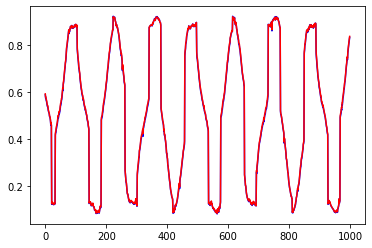

In [56]:
plt.plot(train_scaled[0:1000,0:1],'b')
plt.plot(decoder_out[0:1000,0:1],'r')

In [57]:
np.mean(tf.keras.losses.mae(decoder_out, train_scaled))

0.004751247518910588

Testing on anomalous ( less anomalous )

In [58]:
encoder_out_a = model.encoder(anomalous_scaled).numpy()
decoder_out_a = model.decoder(encoder_out_a).numpy()

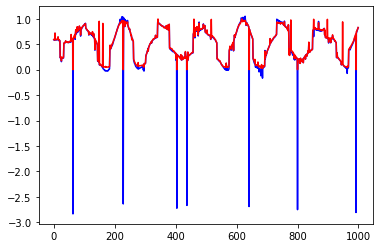

In [59]:
plt.plot(anomalous_scaled[0:1000,0:1],'b')
plt.plot(decoder_out_a[0:1000,0:1],'r')

In [61]:
np.mean(tf.keras.losses.mae(decoder_out_a, anomalous_scaled))

0.03909676052243761

Testing on noisy

In [34]:
noisy = pd.read_csv('/content/drive/MyDrive/induction_motor/noisy_data.csv')
noisy_scaled = train_scaler.transform(noisy)


<AxesSubplot:>

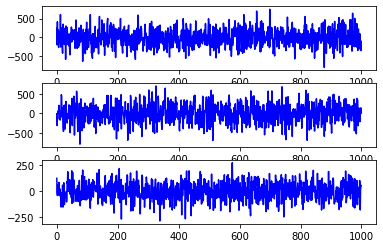

In [63]:
plt.subplot(3, 1, 1)
plt.plot(noisy['current_1'].loc[0:1000],'b',label='anomalous')
plt.subplot(3, 1, 2)
plt.plot(noisy['current_2'].loc[0:1000],'b',label='anomalous')
plt.subplot(3, 1, 3)
plt.plot(noisy['current_3'].loc[0:1000],'b',label='anomalous')
plt.subplot(3, 1, 1)

In [64]:
encoder_out_n = model.encoder(noisy_scaled).numpy()
decoder_out_n = model.decoder(encoder_out_a).numpy()

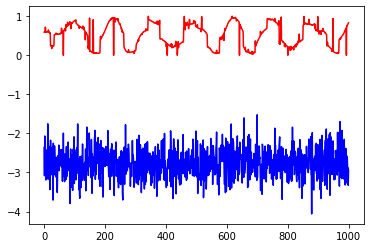

In [65]:
plt.plot(noisy_scaled[0:1000,0:1],'b')
plt.plot(decoder_out_n[0:1000,0:1],'r')

In [74]:
decoder_out_n.shape, noisy_scaled.shape

((10000, 3), (1000, 3))

In [75]:
np.mean(tf.keras.losses.mae(decoder_out_n[0:1000], noisy_scaled))


2.391773482258329

more anomalous data

In [39]:
df_a = modules.AnomalyGenerator.add_anomalies(normal_data[0:10000], spike_magnitude=50,spike_probability=0.02, dropout_probability=0.01, drift_amplitude=300, drift_frequency=0.01,transient_magnitude=1000, transient_duration=1000)

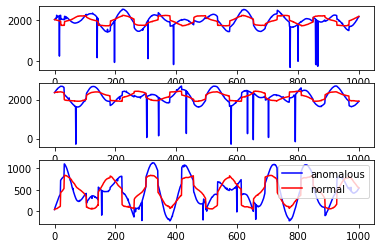

In [40]:
plt.subplot(3, 1, 1)
plt.plot(df_a['current_1'].loc[0:1000],'b',label='anomalous')
plt.subplot(3, 1, 2)
plt.plot(df_a['current_2'].loc[0:1000],'b',label='anomalous')
plt.subplot(3, 1, 3)
plt.plot(df_a['current_3'].loc[0:1000],'b',label='anomalous')
plt.subplot(3, 1, 1)
plt.plot(normal_data['current_1'].loc[0:1000],'r',label='normal')
plt.subplot(3, 1, 2)
plt.plot(normal_data['current_2'].loc[0:1000],'r',label='normal')
plt.subplot(3, 1, 3)
plt.plot(normal_data['current_3'].loc[0:1000],'r',label='normal')
plt.legend()

In [43]:
df_a_scaled = train_scaler.transform(df_a)

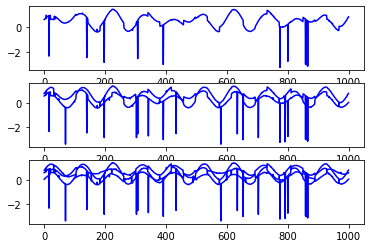

In [45]:
plt.subplot(3, 1, 1)
plt.plot(df_a_scaled[0:1000,0:1],'b',label='anomalous')
plt.subplot(3, 1, 2)
plt.plot(df_a_scaled[0:1000,0:2],'b',label='anomalous')
plt.subplot(3, 1, 3)
plt.plot(df_a_scaled[0:1000,0:3],'b',label='anomalous')

In [76]:
encoder_out_df_a = model.encoder(df_a_scaled).numpy()
decoder_out_df_a = model.decoder(encoder_out_df_a).numpy()

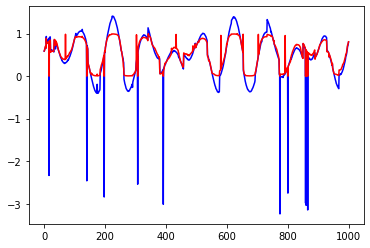

In [77]:
plt.plot(df_a_scaled[0:1000,0:1],'b')
plt.plot(decoder_out_df_a[0:1000,0:1],'r')

In [78]:
np.mean(tf.keras.losses.mae(decoder_out_df_a, df_a_scaled))

0.22390506598712154

visualizing losses on train data and calculating a threshold for anomalies

In [80]:
reconstructions = model.predict(train_scaled)
train_loss = tf.keras.losses.mae(reconstructions, train_scaled)

99063/99063 [==============================] - 188s 2ms/step


<AxesSubplot:ylabel='Density'>

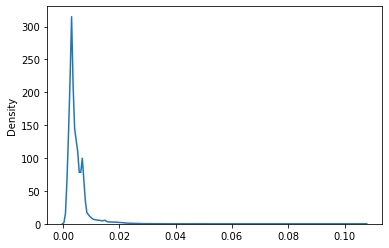

In [81]:
import seaborn as sns
sns.kdeplot(train_loss, bw_adjust= 0.5)

In [89]:
threshold = np.mean(train_loss) + 4*np.std(train_loss)

In [90]:
threshold

0.018222184757430586

In [91]:
np.sum(train_loss > threshold)

42375

find indices and files of anomalies

In [92]:
indices = np.where(tf.math.less(train_loss, threshold) == False)[0]

In [93]:

file_size = 10000
num_files = len(train_scaled) // file_size

# Create histogram of indices based on file number
hist, bin_edges = np.histogram(indices, bins=num_files, range=(0, len(train_scaled)))
file_indices = np.digitize(indices, bin_edges[:-1])

# Count number of anomalies per file
file_counts = {}
for i in range(1, num_files+1):
    file_counts[i] = np.count_nonzero(file_indices == i)

# Sort files by number of anomalies (in descending order)
sorted_files = sorted(file_counts.items(), key=lambda x: x[1], reverse=True)

# Print results
for file_num, count in sorted_files:
    print(f"File {file_num}: {count} anomalies")

File 219: 1705 anomalies
File 217: 1630 anomalies
File 218: 1619 anomalies
File 220: 1619 anomalies
File 224: 1609 anomalies
File 215: 1598 anomalies
File 225: 1598 anomalies
File 216: 1589 anomalies
File 221: 1571 anomalies
File 210: 1562 anomalies
File 212: 1560 anomalies
File 214: 1555 anomalies
File 213: 1553 anomalies
File 199: 1544 anomalies
File 207: 1510 anomalies
File 209: 1468 anomalies
File 208: 1452 anomalies
File 198: 1448 anomalies
File 201: 1435 anomalies
File 206: 1430 anomalies
File 203: 1394 anomalies
File 204: 1384 anomalies
File 205: 1380 anomalies
File 202: 1256 anomalies
File 240: 1186 anomalies
File 236: 916 anomalies
File 233: 855 anomalies
File 231: 785 anomalies
File 232: 771 anomalies
File 230: 324 anomalies
File 235: 286 anomalies
File 229: 239 anomalies
File 241: 132 anomalies
File 226: 94 anomalies
File 197: 36 anomalies
File 243: 25 anomalies
File 196: 15 anomalies
File 36: 5 anomalies
File 39: 5 anomalies
File 42: 4 anomalies
File 49: 4 anomalies
File 29

For real Real time : generator function that reads and yields batches of data from the files as they come

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, file_paths, batch_size):
    self.file_paths = file_paths
    self.batch_size = batch_size

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self, idx):
    file_path = self.file_paths[idx]
    data = load_data(file_path) # implement this function to load data from file
    batch_idx = 0
    while (batch_idx + 1) * self.batch_size <= len(data):
      batch = data[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]
      batch_idx += 1
      yield batch, batch # return the batch as both x and y, since this is an unsupervised learning task

# Define the file paths
file_paths = [...] # list of file paths

# Initialize the data generator
batch_size = 128
data_generator = DataGenerator(file_paths, batch_size)

# Initialize the model
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
model.compile(optimizer='adam', loss='mae')

# Train the model
for epoch in range(50):
  print(f'Epoch {epoch+1}/{50}')
  for i, (x, y) in enumerate(data_generator):
    loss = model.train_on_batch(x, y)
    print(f'Batch {i+1}/{len(data_generator)} - Loss: {loss:.4f}')


`DataGenerator` class inherits from `tf.keras.utils.Sequence` and implements the `__len__` and `__getitem__` methods. The `__len__` method returns the number of files in the `file_paths list`, and the `__getitem__` method reads and yields batches of data from each file. The `train_on_batch` method is used to train the model on each batch of data, and the progress is printed to the console. The outer loop iterates over epochs, and the inner loop iterates over files using the `DataGenerator`.